In [1]:
import lightgbm


import boruta

import sklearn.feature_selection as fs

import numpy as np

import fri
from sklearn.preprocessing import scale

%matplotlib inline

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.model_selection import cross_val_score

import sklearn.feature_selection as fs
from sklearn.model_selection import ParameterGrid


def get_fs(estimator, X=None, y=None):
    fset = fs.SelectFromModel(
        prefit=True, estimator=estimator, threshold="mean"
    ).get_support()
    # fset = fs.RFECV(estimator=estimator,cv=3).fit(X,y).get_support()
    return fset


def model(random_state=None, params=None):
    return lightgbm.LGBMClassifier(random_state=random_state, **params)


def train_and_get_imps(X, y, random_state, params=None):
    rf = model(random_state=random_state, params=params)
    rf.fit(X, y)

    return rf.feature_importances_

In [2]:
from sklearn.feature_selection import mutual_info_classif as mi
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 10))
# sns.swarmplot(data=frame)

In [3]:
def plot_imp_list(imp_list, line=True, color=None):
    fig, ax1 = plt.subplots()
    frame = pd.DataFrame(imp_list)
    frame.plot(kind="box", ax=ax1, color=color)
    if line:
        for q in frame.mean(1).quantile([0.1, 0.5, 0.9]):
            plt.axhline(q)


def plot_class_list(imp_list):
    fig, ax1 = plt.subplots()
    frame = pd.DataFrame(imp_list).mean()
    frame.plot(kind="bar", ax=ax1)

ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7f7904299dd0>)
Traceback (most recent call last):
  File "/home/lpfannschmidt/.cache/pypoetry/virtualenvs/squamish-ys7rEhGb-py3.7/lib64/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/lpfannschmidt/.cache/pypoetry/virtualenvs/squamish-ys7rEhGb-py3.7/lib64/python3.7/site-packages/ipykernel/kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [4]:
def get_relev_class_RFE(X, y, random_state=None, params=None):
    rfc = fs.RFECV(model(random_state=random_state, params=params), cv=5)
    rfc.fit(X, y)
    return rfc.support_.astype(int)

In [8]:
def data(informative=5, redundant=10, d=17, n=300):
    STATE = np.random.RandomState(seed=1231241)

    X, y = fri.genClassificationData(
        n_features=d,
        n_redundant=redundant,
        n_strel=informative,
        n_samples=n,
        random_state=STATE,
    )
    X = scale(X)
    return X, y


def benchmark(best_params_rf, X, y):
    STATE = np.random.RandomState(seed=1231241)

    imp_list = [
        train_and_get_imps(
            X, y, random_state=STATE.randint(1000), params=best_params_rf
        )
        for t in range(10)
    ]

    plot_imp_list(imp_list)
    plt.title("Distribution of importance values")
    rel_class_list = [
        get_relev_class_RFE(
            X, y, random_state=STATE.randint(1000), params=best_params_rf
        )
        for t in range(10)
    ]
    plot_class_list(rel_class_list)
    plt.title("Frequency of inclusion in Minimal Feature Set (RFECV)")


def borutabench(best_params_rf, X, y):
    bor = boruta.BorutaPy(model(params=best_params_rf))
    bor.fit(X, y)
    bor.support_

    plot_class_list([bor.support_])
    plt.title("Frequency of inclusion in AllRel Set (Boruta)")

# Gain Importance

## 0.5 Feature Fraction

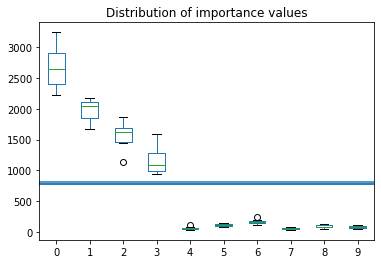

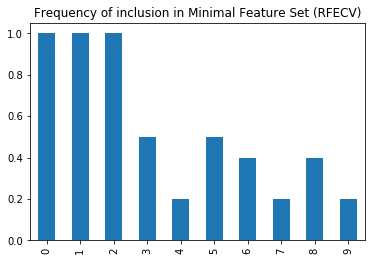

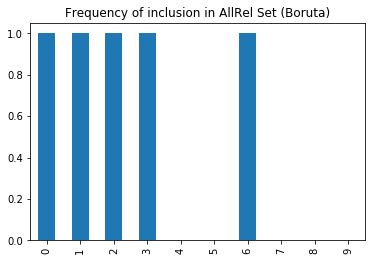

In [12]:
best_params_rf = {
    "max_depth": [5],
    "boosting_type": ["rf"],
    "bagging_fraction": [0.632],
    "bagging_freq": [1],
    "feature_fraction": [0.5],
    "importance_type": ["gain"],
}
X, y = data(informative=2, redundant=2, d=10, n=300)
best_params_rf = ParameterGrid(best_params_rf)[0]
benchmark(best_params_rf, X, y)
borutabench(best_params_rf, X, y)

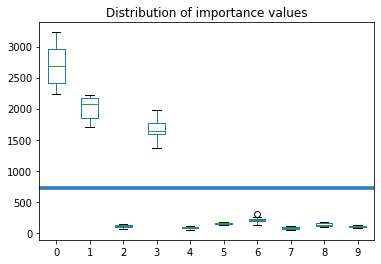

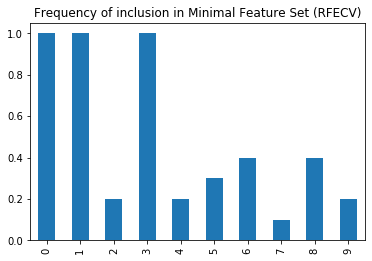

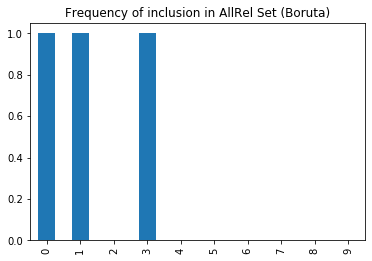

In [13]:
best_params_rf = {
    "max_depth": [5],
    "boosting_type": ["rf"],
    "bagging_fraction": [0.632],
    "bagging_freq": [1],
    "feature_fraction": [0.5],
    "importance_type": ["gain"],
}
X, y = data(informative=2, redundant=2, d=10, n=300)
X[:,2] = np.random.permutation(X[:,2])

best_params_rf = ParameterGrid(best_params_rf)[0]
benchmark(best_params_rf, X, y)
borutabench(best_params_rf, X, y)